In [1]:
import numpy as np
import random
from copy import deepcopy
from collections import Counter, defaultdict
from datetime import datetime
from pickle import dump
from os.path import exists
from os import makedirs
import sys
import argparse
import warnings
import os
from tqdm import tqdm
# warnings.simplefilter("ignore", UserWarning)

from joblib import Parallel, delayed
import time

from sklearn.utils import check_random_state
# from sklearn.utils import resample
from sklearn.metrics import classification_report, balanced_accuracy_score, fbeta_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

# Sklearn Optimize
from skopt.space import Real, Integer, Categorical
from skopt import forest_minimize  # gp_minimize
from skopt.utils import use_named_args

# Imbalance Learn
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler  # EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.combine import SMOTEENN

# Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

#import mixup modules
from mixup import mix
from mixup import mixupreg
from mixup import converttohardlabel
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.utils.extmath import softmax
from sklearn.metrics import classification_report, balanced_accuracy_score, fbeta_score
#import matplotlib.pyplot.plot as plt

In [2]:
x_path = "/Users/yeganehghamari/epilepsy-project/data/multiclass_X_new.npy"
y_path = "/Users/yeganehghamari/epilepsy-project/data/multiclass_y_new.npy"
groups_path = "/Users/yeganehghamari/epilepsy-project/data/multiclass_patients_new.npy"

verbose = True
seed = 55784899
#n_inner = 5
#n_outer = 5
n_inner = 1
n_outer = 2
n_repeats = 1

np.random.seed(seed)
random.seed(seed)
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

'''def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

'''


'def softmax(x):\n    """Compute softmax values for each sets of scores in x."""\n    e_x = np.exp(x - np.max(x))\n    return e_x / e_x.sum(axis=0) # only difference\n\n'

In [3]:
class StratifiedGroupKFold():

    def __init__(self, k=5, n_repeats=1, seed=None):
        self.k = k  # Number of folds
        self.n_repeats = n_repeats  # Number of repeats
        self.seed = seed  # Random seed for reproducibility

    # Implementation inspired by Kaggle
    # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    def split(self, X, y=None, groups=None):
        random_state = check_random_state(self.seed)  # Random state generator

        # Repeat k-fold n_splits time with unique folds
        for repeat in range(self.n_repeats):
            labels_num = len(np.unique(y))  # Number of labels

            # Calculate the label distribution for each group
            y_counts_per_group = defaultdict(lambda: np.zeros(labels_num, dtype=int))
            y_distr = Counter()
            print(y_distr, y_counts_per_group)
            for label, g in zip(y, groups):
                y_counts_per_group[g][label] += 1
                y_distr[label] += 1

            fold_counts = defaultdict(lambda: np.zeros(labels_num, dtype=int))
            groups_per_fold = defaultdict(set)

            # Shuffle the groups
            label_counts = list(y_counts_per_group.items())
            random_state.shuffle(label_counts)

            '''
            For each group and its label distribution add the group to the
            fold that would cause the least standard deviation from the
            original distribution.
            '''

            for g, label_counts in label_counts:
                best_fold = None
                min_eval = None
                for fold in range(self.k):
                    fold_counts[fold] += label_counts
                    std_per_label = []
                    for l in range(labels_num):
                        label_std = np.std([fold_counts[i][l] / y_distr[l] for i in range(self.k)])
                        std_per_label.append(label_std)

                    fold_counts[fold] -= label_counts

                    fold_eval = np.mean(std_per_label)

                    if min_eval == None or fold_eval < min_eval:
                        min_eval = fold_eval
                        best_fold = fold

                fold_counts[best_fold] += label_counts
                groups_per_fold[best_fold].add(g)

            all_groups = np.unique(groups)  # Get all unique groups
            for fold in range(self.k):
                train_groups = np.setdiff1d(all_groups, list(groups_per_fold[fold]))
                test_groups = list(groups_per_fold[fold])

                train_indices = np.where(np.isin(groups, list(train_groups)))[0]
                test_indices = np.where(np.isin(groups, list(test_groups)))[0]

                # Yields the indices as they are needed
                yield repeat, fold, train_indices, test_indices


In [4]:
X = np.load(x_path)
X = X.reshape(-1, np.product(X.shape[1:]))
y = np.load(y_path)
num_classes = len(np.unique(y))

patients = np.load(groups_path, allow_pickle=True)
groups = np.empty(len(patients), dtype=int)
# %%

unique_patients = np.unique(patients)
unique_groups = np.arange(len(unique_patients))
for i, patient in enumerate(unique_patients):
    groups[patients == patient] = i

# %%

best_hyperparametes = []
#n_mix = [20]
#n_mix = [0, 10]
#n_mix = [20, 200, 2000, 12000] #/2 mixup samples with same number of labels method
n_mix = [0, 20, 200, 10000, 100000] #/2 for DIFFERENT
#n_origin = [10, 100, 1000, 6000] # each class
n_origin = [0, 10, 100, 5000, 50000] #in total for DIFFERENT #LABELS 
#n_origin = [0, 10]

#ypred = np.empty((n_repeats, len(mix), len(y),), dtype=int)
#ypred = np.empty((n_repeats, n_outer, len(n_mix), len(y)), dtype=float)

model = MLPRegressor(activation = 'logistic')
groups



array([  0,   0,   0, ..., 301, 301, 301])

NameError: name 'ypar' is not defined

In [11]:
#hold out CV with same and DIFFERENT label distributions

_, _ , train_idx, test_idx = list(StratifiedGroupKFold(k=5, n_repeats=1, seed=seed).split(X,y, groups))[0]
trainx, trainy, Xval, yval = X[train_idx], y[train_idx], X[test_idx], y[test_idx] #20% test
ypred = np.zeros(len(yval), dtype=float)
#sampler = RandomUnderSampler(sampling_strategy={5: 10000})
sampler = RandomUnderSampler(sampling_strategy={5: 35000})#with DIFFERENT number of samples in each label 
Xpar, ypar = sampler.fit_resample(trainx,trainy)
Xpar, ypar = shuffle(Xpar, ypar)

accuracy = np.zeros((len(n_origin), len(n_mix)), dtype = float)
baccuracy = np.zeros((len(n_origin), len(n_mix)), dtype = float)
fscore = np.zeros((len(n_origin), len(n_mix)), dtype = float)

Counter() defaultdict(<function StratifiedGroupKFold.split.<locals>.<lambda> at 0x7f80215ae8b0>, {})


In [12]:
print(np.shape(Xpar), np.shape(ypar), np.shape(Xval), np.shape(yval))
print(accuracy.shape, baccuracy.shape, fscore.shape)

(100549, 475) (100549,) (276852, 475) (276852,)
(5, 5) (5, 5) (5, 5)


In [13]:
np.count_nonzero(ypar == 5), np.count_nonzero(ypar == 4), np.count_nonzero(ypar == 3), np.count_nonzero(ypar == 2), np.count_nonzero(ypar == 1), np.count_nonzero(ypar == 0)



(35000, 5175, 16560, 25939, 9597, 8278)

In [125]:
#kfold CV with DIFFERENT LABEL distribution
outerfold = StratifiedGroupKFold(k=n_outer, n_repeats=n_repeats, seed=seed)

ypred = np.empty((n_repeats, len(y)), dtype=float)
ypred.fill(0)

ypredtotal = np.empty((len(n_origin),len(n_mix)), dtype=float)
ypred.fill(0)


In [22]:
#with loops over different fake and original values, same number of labels in training set
# -----------------------------------------------------------------------

#choose batch from training set
#for N in []
for N in n_origin:
        #N = 1/10
    
        if N == 0:
            Xpar1, ypar1 = Xpar, ypar
        else:
            zeros, ones, twos, threes, fours, fives = np.where(ypar==0)[0], np.where(ypar==1)[0], np.where(ypar==2)[0], np.where(ypar==3)[0], np.where(ypar==4)[0], np.where(ypar==5)[0]
            zeros, ones, twos, threes, fours, fives = shuffle(zeros), shuffle(ones), shuffle(twos), shuffle(threes), shuffle(fours), shuffle(fives) 
            zero, one, two, three, four, five = zeros[:N], ones[:N], twos[:N], threes[:N], fours[:N], fives[:N]
            #zero, one, two, three, four, five = zeros[:int(N*len(zeros))], ones[:int(N*len(ones))], twos[:int(N*len(twos))], threes[:int(N*len(threes))], fours[:int(N*len(fours))], fives[:int(N*len(fives))]

            ind = np.concatenate((zero, one, two, three, four, five))

            Xpar1, ypar1 = Xpar[ind], ypar[ind]
            #Xpar1, ypar1 = Xpar[:int(N*len(ypar))], ypar[:int(N*len(ypar))]
            #shuffler = np.random.permutation(len(Xtrain))
            #Xtrain, ytrain = Xtrain[shuffler], ytrain[shuffler]
            Xpar1, ypar1 = shuffle(Xpar1, ypar1)

        #Xtest, ytest = shuffle(Xtest, ytest)
        #shuffler2 = np.random.permutation(len(Xtest))
        #Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]
        ohe = OneHotEncoder()
        ohe.fit([[0],[1],[2],[3],[4],[5]])
        ypar1 = ohe.transform(ypar1.reshape(-1,1)).toarray()
        #yval = ohe.transform(yval.reshape(-1,1)).toarray()
        print(np.shape(Xpar1), np.shape(ypar1))
        #Xtrain = [Xtrain[i] + np.random.rand for i in range(len(Xtrain))]
        #standardize
        scaler = StandardScaler().fit(Xpar1)
        Xpar1 = scaler.transform(Xpar1)
        Xval = scaler.transform(Xval)
        
        for i in range(len(n_mix)):
            if N == 0 and i == 0:
                
                accuracy[0, 0] = 0
                baccuracy[0,0] = 0
                fscore[0,0] = 0
            else:
                
                if i == 0 and N!= 0:
                    X_train_mix, y_train_mix = Xpar1, ypar1
                
                elif N == 0 and i != 0:
                    X_train_mix, y_train_mix = mixupreg(Xpar1, ypar1, n_mix[i], alpha = 0.4)


                elif i != 0 and N!=0 and N*6>= n_mix[i]:
                    #mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, mix[i], alpha = 0.4)
                    mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, n_mix[i], alpha = 0.4)
                    X_train_mix, y_train_mix = np.concatenate([mix_Xs, Xpar1]), np.concatenate([mix_ys, ypar1])

                mixind  = np.where(y_train_mix == mix_ys)
                scaler2 = StandardScaler().fit(X_train_mix)
                X_train_mix = scaler2.transform(X_train_mix)
                X_test_mix = scaler2.transform(Xval)

                print('Information about the new datasets')
                print('Training set shape:', X_train_mix.shape)
                print('Test set shape', X_test_mix.shape)
                print(y_train_mix.shape, yval.shape)

                model.fit(X_train_mix, y_train_mix)

                y_pred1 = model.predict(X_test_mix)
                y_pred = softmax(y_pred1)
                y_pred_classes = y_pred.argmax(1)
                print('ypred', y_pred)
                print('ypredshape', y_pred.shape)
                print('ypredclass', y_pred_classes)
                print('yval', yval)
                #y_val_classes = yval.argmax(1)
                #ypred[repeat][fold][i][val_idxs] = y_pred_classes
                accuracy[n_origin.index(N), i] = np.mean(y_pred_classes == yval) * 100
                baccuracy[n_origin.index(N), i] = balanced_accuracy_score(y_pred_classes, yval) * 100
                fscore[n_origin.index(N), i] = round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3)

                #print("Test data: Accuracy:", np.mean(y_pred_classes == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: Balanced accuracy:", balanced_accuracy_score(y_pred_classes, yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
                #print("Test: Weighted F1-Score:", round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print()

                #print('ypred', ypred.shape)
                #print('ypredclass', ypred[repeat][fold][i][val_idxs])
                #print("Test data: Accuracy:", np.mean(ypred[repeat][fold][i][val_idxs] == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: Balanced accuracy:", balanced_accuracy_score(ypred[repeat][fold][i][val_idxs], yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
                #print("Test: Weighted F1-Score:", round(f1_score(ypred[repeat][fold][i][val_idxs], yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print()


(75549, 475) (75549, 6)
5
(5, 6) (5, 6)
0.25816290188143726
0.003671443418501168
0.1729746291193952
0.9582910349413212
0.999612614487336
Information about the new datasets
Training set shape: (5, 475)
Test set shape (276852, 475)
(5, 6) (276852,)
ypred [[0.22464813 0.06422385 0.14501675 0.17530459 0.24759928 0.1432074 ]
 [0.21976505 0.07249163 0.14569312 0.15994413 0.24110652 0.16099955]
 [0.22182443 0.07008173 0.1455485  0.16763054 0.2370984  0.1578164 ]
 ...
 [0.16937769 0.22178913 0.15714686 0.13117946 0.12038836 0.20011849]
 [0.17149335 0.1955067  0.12490695 0.12557133 0.12455966 0.25796201]
 [0.18977988 0.17142232 0.18815939 0.11955491 0.12908797 0.20199553]]
ypredshape (276852, 6)
ypredclass [4 4 4 ... 1 5 5]
yval [5 5 5 ... 5 5 5]
(60, 475) (60, 6)


<ipython-input-22-c4538977524e>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (60, 475)
Test set shape (276852, 475)
(60, 6) (276852,)
ypred [[0.13509255 0.27149097 0.1254433  0.17631454 0.10018241 0.19147623]
 [0.15698366 0.22779918 0.13663532 0.18597418 0.11502277 0.17758489]
 [0.14722455 0.23622344 0.14252839 0.18093974 0.11875501 0.17432887]
 ...
 [0.13424494 0.22000566 0.12845861 0.13839275 0.20428447 0.17461357]
 [0.13913997 0.23313526 0.143096   0.12487686 0.17841652 0.18133539]
 [0.14110099 0.20580295 0.11799936 0.14540038 0.22859726 0.16109907]]
ypredshape (276852, 6)
ypredclass [1 1 1 ... 1 1 4]
yval [5 5 5 ... 5 5 5]
5
(5, 6) (5, 6)
0.027800317648103964
0.00837568223456279
0.9255947049012851
0.8970160084237092
0.9394052125803334


<ipython-input-22-c4538977524e>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (65, 475)
Test set shape (276852, 475)
(65, 6) (276852,)
ypred [[0.14809234 0.25497766 0.10501501 0.18300043 0.11019424 0.19872032]
 [0.15654885 0.23319743 0.10688811 0.21716668 0.11466321 0.17153573]
 [0.15184296 0.23663176 0.11418629 0.20838742 0.11597976 0.17297182]
 ...
 [0.15357655 0.20997138 0.11268793 0.13246275 0.18307383 0.20822756]
 [0.12480001 0.22277472 0.13399615 0.1208934  0.18497918 0.21255654]
 [0.15241614 0.19416693 0.12082445 0.1367633  0.17233024 0.22349894]]
ypredshape (276852, 6)
ypredclass [1 1 1 ... 1 1 5]
yval [5 5 5 ... 5 5 5]


In [14]:
#with loops over different fake and original values, DIFFERENT number of labels in training set
# -----------------------------------------------------------------------

#choose batch from training set
#for N in []
for N in n_origin:
        #N = 1/10
    
        if N == 0:
            Xpar1, ypar1 = Xpar, ypar
        else:


            Xpar1, ypar1 = Xpar[:N], ypar[:N]
            Xpar1, ypar1 = shuffle(Xpar1, ypar1)

        #Xtest, ytest = shuffle(Xtest, ytest)
        #shuffler2 = np.random.permutation(len(Xtest))
        #Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]
        ohe = OneHotEncoder()
        ohe.fit([[0],[1],[2],[3],[4],[5]])
        ypar1 = ohe.transform(ypar1.reshape(-1,1)).toarray()
        #yval = ohe.transform(yval.reshape(-1,1)).toarray()
        print(np.shape(Xpar1), np.shape(ypar1))
        #Xtrain = [Xtrain[i] + np.random.rand for i in range(len(Xtrain))]
        #standardize
        scaler = StandardScaler().fit(Xpar1)
        Xpar1 = scaler.transform(Xpar1)
        Xval = scaler.transform(Xval)
        
        for i in range(len(n_mix)):
            
            if N == 0 and i == 0:
                
                accuracy[0, 0] = 0
                baccuracy[0,0] = 0
                fscore[0,0] = 0
            else:
                
                if i == 0 and N!= 0:
                    X_train_mix, y_train_mix = Xpar1, ypar1
                
                elif N == 0 and i != 0:
                    X_train_mix, y_train_mix = mixupreg(Xpar1, ypar1, n_mix[i], alpha = 0.4)

                elif i != 0 and 2*N >= n_mix[i]:
                    #mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, mix[i], alpha = 0.4)
                    mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, n_mix[i], alpha = 0.4)
                    X_train_mix, y_train_mix = np.concatenate([mix_Xs, Xpar1]), np.concatenate([mix_ys, ypar1])

                #mixind  = np.where(y_train_mix == mix_ys)
                scaler2 = StandardScaler().fit(X_train_mix)
                X_train_mix = scaler2.transform(X_train_mix)
                X_test_mix = scaler2.transform(Xval)

                print('Information about the new datasets')
                print('Training set shape:', X_train_mix.shape)
                print('Test set shape', X_test_mix.shape)
                print(y_train_mix.shape, yval.shape)

                model.fit(X_train_mix, y_train_mix)

                y_pred1 = model.predict(X_test_mix)
                y_pred = softmax(y_pred1)
                y_pred_classes = y_pred.argmax(1)
                print('ypred', y_pred)
                print('ypredshape', y_pred.shape)
                print('ypredclass', y_pred_classes)
                print('yval', yval)
                #y_val_classes = yval.argmax(1)
                #ypred[repeat][fold][i][val_idxs] = y_pred_classes
                accuracy[n_origin.index(N), i] = np.mean(y_pred_classes == yval) * 100
                baccuracy[n_origin.index(N), i] = balanced_accuracy_score(y_pred_classes, yval) * 100
                fscore[n_origin.index(N), i] = round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3)

                #print("Test data: Accuracy:", np.mean(y_pred_classes == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: Balanced accuracy:", balanced_accuracy_score(y_pred_classes, yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
                #print("Test: Weighted F1-Score:", round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print()

                #print('ypred', ypred.shape)
                #print('ypredclass', ypred[repeat][fold][i][val_idxs])
                #print("Test data: Accuracy:", np.mean(ypred[repeat][fold][i][val_idxs] == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: Balanced accuracy:", balanced_accuracy_score(ypred[repeat][fold][i][val_idxs], yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
                #print("Test: Weighted F1-Score:", round(f1_score(ypred[repeat][fold][i][val_idxs], yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
                #print()


(100549, 475) (100549, 6)
10
(10, 6) (10, 6)
Information about the new datasets
Training set shape: (10, 475)
Test set shape (276852, 475)
(10, 6) (276852,)
ypred [[0.20425754 0.16979059 0.16558253 0.13168525 0.14910889 0.17957519]
 [0.16335194 0.1880246  0.16825049 0.13007448 0.15930433 0.19099416]
 [0.16973457 0.18438641 0.16749621 0.12124519 0.15835939 0.19877823]
 ...
 [0.26915811 0.16466776 0.1400952  0.17276239 0.10350235 0.14981419]
 [0.17371599 0.14902676 0.19965417 0.2112807  0.14434381 0.12197856]
 [0.17501505 0.15276793 0.16041463 0.2095584  0.16152395 0.14072004]]
ypredshape (276852, 6)
ypredclass [0 5 5 ... 0 3 3]
yval [5 5 5 ... 5 5 5]
100
(100, 6) (100, 6)
Information about the new datasets
Training set shape: (100, 475)
Test set shape (276852, 475)
(100, 6) (276852,)
ypred [[0.18841454 0.07402687 0.18162609 0.17477725 0.0808408  0.30031446]
 [0.16622471 0.07945228 0.13785398 0.1512914  0.09392184 0.37125578]
 [0.17196892 0.07187009 0.1308536  0.14074073 0.09890152 0.385

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
print('ACCURACY:\n', accuracy)
print('BALANCED ACC\n',  baccuracy)
print('F1SCORE\n', fscore)
import seaborn as sns
ax = sns.heatmap(accuracy, linewidth=0.5, yticklabels=n_origin, xticklabels=n_mix)
plt.title('accuracy across combinations')
plt.xlabel('Mixup')
plt.ylabel('Original')
plt.show()

In [128]:
#kfold CV for DIFFERENT SIZE VALUES
for repeat, fold, par_idxs, val_idxs in tqdm(outerfold.split(X, y, groups)):
        #print(par_idxs)
        print('type', val_idxs)
        Xpar, ypar = X[par_idxs], y[par_idxs]
        Xval, yval = X[val_idxs], y[val_idxs]

        # -----------------------------------------------------------------------
        print(np.shape(Xpar), np.shape(ypar), np.shape(Xval), np.shape(yval))
        #choose batch from training set
        #for N in []
        for N in n_origin:
        #N = 1/10
    
            if N == 0:
                Xpar1, ypar1 = Xpar, ypar
            else:


                Xpar1, ypar1 = Xpar[:N], ypar[:N]
                Xpar1, ypar1 = shuffle(Xpar1, ypar1)

            #Xtest, ytest = shuffle(Xtest, ytest)
            #shuffler2 = np.random.permutation(len(Xtest))
            #Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]
            ohe = OneHotEncoder()
            ohe.fit([[0],[1],[2],[3],[4],[5]])
            ypar1 = ohe.transform(ypar1.reshape(-1,1)).toarray()
            #yval = ohe.transform(yval.reshape(-1,1)).toarray()
            print(np.shape(Xpar1), np.shape(ypar1))
            #Xtrain = [Xtrain[i] + np.random.rand for i in range(len(Xtrain))]
            #standardize
            scaler = StandardScaler().fit(Xpar1)
            Xpar1 = scaler.transform(Xpar1)
            Xval = scaler.transform(Xval)

            for i in range(len(n_mix)):
                if i == 0 and N!= 0:
                    X_train_mix, y_train_mix = Xpar1, ypar1

                elif N == 0 and i != 0:
                    X_train_mix, y_train_mix = mixupreg(Xpar1, ypar1, n_mix[i], alpha = 0.4)

                elif N == 0 and i == 0:
                    X_train_mix, y_train_mix = np.zeros(np.shape(Xpar1)), np.zeros(np.shape(ypar1))

                elif i != 0 and N!=0 and N>= n_mix[i]:
                    #mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, mix[i], alpha = 0.4)
                    mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, n_mix[i], alpha = 0.4)
                    X_train_mix, y_train_mix = np.concatenate([mix_Xs, Xpar1]), np.concatenate([mix_ys, ypar1])

                #mixind  = np.where(y_train_mix == mix_ys)
                scaler2 = StandardScaler().fit(X_train_mix)
                X_train_mix = scaler2.transform(X_train_mix)
                X_test_mix = scaler2.transform(Xval)

                print('Information about the new datasets')
                print('Training set shape:', X_train_mix.shape)
                print('Test set shape', X_test_mix.shape)
                print(y_train_mix.shape, yval.shape)

                model.fit(X_train_mix, y_train_mix)

                y_pred1 = model.predict(X_test_mix)
                y_pred = softmax(y_pred1)
                y_pred_classes = y_pred.argmax(1)
                print('ypred', y_pred)
                print('ypredshape', y_pred.shape)
                print('ypredclass', y_pred_classes)
                print('yval', yval)
                #y_val_classes = yval.argmax(1)
                #ypred[repeat][fold][i][val_idxs] = y_pred_classes
                ypred[repeat][val_idxs] = y_pred_classes
                print(ypred)
                #ypredtotal[i, n_origin.index(N)] = ypred
                #print(ypredtotal)
                print(classification_report(np.tile(y, n_repeats), ypred.flatten(), target_names=list(label_dict.keys())))
                
            '''accuracy[n_origin.index(N), i] = np.mean(y_pred_classes == yval) * 100
            baccuracy[n_origin.index(N), i] = balanced_accuracy_score(y_pred_classes, yval) * 100
            fscore[n_origin.index(N), i] = round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3)
            '''

            '''print('Information about the new datasets')
            print('Training set shape:', X_train_mix.shape)
            print('Test set shape', X_test_mix.shape)
            print(y_train_mix.shape, yval.shape)

            model.fit(X_train_mix, y_train_mix)

            y_pred = model.predict(X_test_mix)
            y_pred_classes = y_pred.argmax(1)
            print('ypred', y_pred)
            print('ypredshape', y_pred.shape)
            print('ypredclass', y_pred_classes)
            print('yval', yval)
            #y_val_classes = yval.argmax(1)
            #ypred[repeat][fold][i][val_idxs] = y_pred_classes
            accuracy[fold, i] = np.mean(y_pred_classes == yval) * 100
            baccuracy[fold, i] = balanced_accuracy_score(y_pred_classes, yval) * 100
            fscore[fold, i] = round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3)
            
            print("Test data: Accuracy:", np.mean(y_pred_classes == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            print("Test data: Balanced accuracy:", balanced_accuracy_score(y_pred_classes, yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
            print("Test: Weighted F1-Score:", round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            print()
            
            #print('ypred', ypred.shape)
            #print('ypredclass', ypred[repeat][fold][i][val_idxs])
            #print("Test data: Accuracy:", np.mean(ypred[repeat][fold][i][val_idxs] == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            #print("Test data: Balanced accuracy:", balanced_accuracy_score(ypred[repeat][fold][i][val_idxs], yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
            #print("Test: Weighted F1-Score:", round(f1_score(ypred[repeat][fold][i][val_idxs], yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            print()'''
            

0it [00:00, ?it/s]

Counter() defaultdict(<function StratifiedGroupKFold.split.<locals>.<lambda> at 0x7ffad425cee0>, {})
type [      0       1       2 ... 1386100 1386101 1386102]
(690681, 475) (690681,) (695422, 475) (695422,)
(10, 475) (10, 6)
Information about the new datasets
Training set shape: (10, 475)
Test set shape (695422, 475)
(10, 6) (695422,)
ypred [[0.12919148 0.15391401 0.11226393 0.13616769 0.13884578 0.32961711]
 [0.13420519 0.14829721 0.10391359 0.13801542 0.12158168 0.35398691]
 [0.13926602 0.15109318 0.10683606 0.13441892 0.117575   0.35081082]
 ...
 [0.14486795 0.14519702 0.13510273 0.11048722 0.11368797 0.35065711]
 [0.13317077 0.13174349 0.1299531  0.0850053  0.10207095 0.41805639]
 [0.1265729  0.17363521 0.11047007 0.08931408 0.10910838 0.39089936]]
ypredshape (695422, 6)
ypredclass [5 5 5 ... 5 5 5]
yval [5 5 5 ... 5 5 5]


0it [01:00, ?it/s]

[[5. 5. 5. ... 5. 5. 5.]]


ValueError: setting an array element with a sequence.

0

In [ ]:
#analysis of k fold CV
if verbose:
    label_dict = {'chew': 0, 'elpp': 1, 'eyem': 2, 'musc': 3, 'shiv': 4, 'null': 5}
    print()
    for i in range(len(n_mix)):
        for j in range(len(n_origin)):
            
            print(classification_report(np.tile(y, n_repeats), ypredtotal[j, i].flatten(), target_names=list(label_dict.keys())))

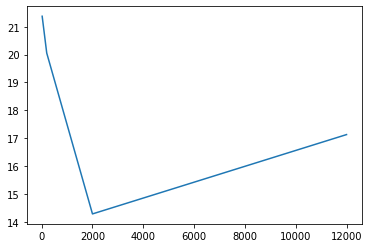

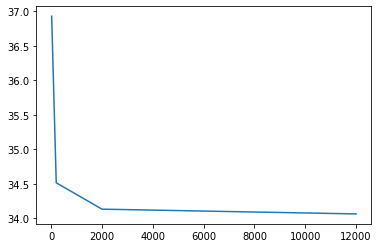

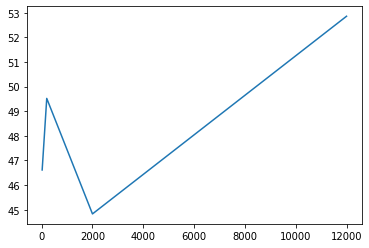

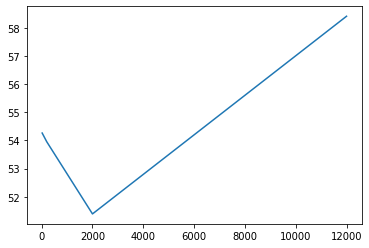

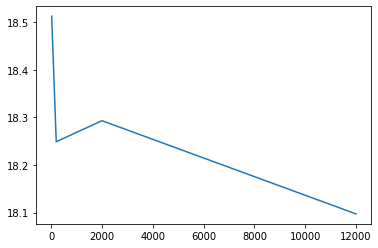

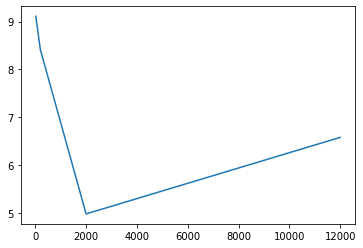

In [108]:
#analysis OF DIFFERENT SIZE LABELED DATA

plt.plot(n_mix, accuracy[0])
plt.show()
plt.plot(n_mix, accuracy[1])
plt.show()
plt.plot(n_mix, accuracy[2])
plt.show()
plt.plot(n_mix, accuracy[3])
plt.show()
plt.plot(n_mix, baccuracy[0])
plt.show()
plt.plot(n_mix, fscore[0])
plt.show()

In [72]:
#FROM HERE TIL END BEFORE ANALYSIS IS DRAFTTTTTTTTT
ypred[0][0][0][[0,2,3]] = np.ones(3,)
ypred


array([[[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],

        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]]])

In [9]:
np.count_nonzero(y == 5), np.count_nonzero(y == 4), np.count_nonzero(y == 3), np.count_nonzero(y == 2), np.count_nonzero(y == 1), np.count_nonzero(y == 0)

(1303270, 6175, 20680, 32369, 11971, 11638)

In [9]:
np.shape(y), np.shape(X), np.count_nonzero(y==5)

((1386103,), (1386103, 475), 1303270)

In [86]:
'''for repeat, fold, par_idxs, val_idxs in tqdm(outerfold.split(X, y, groups)):

    Xpar, ypar = X[par_idxs], y[par_idxs]
    Xval, yval = X[val_idxs], y[val_idxs]

    # -----------------------------------------------------------------------
    #print(np.shape(Xpar), np.shape(ypar), np.shape(Xval), np.shape(yval))
    #choose batch from training set
    N = 1000
    #N = 1/10


    zeros, ones, twos, threes, fours, fives = np.where(ypar==0)[0], np.where(ypar==1)[0], np.where(ypar==2)[0], np.where(ypar==3)[0], np.where(ypar==4)[0], np.where(ypar==5)[0]
    zeros, ones, twos, threes, fours, fives = shuffle(zeros), shuffle(ones), shuffle(twos), shuffle(threes), shuffle(fours), shuffle(fives) 
    zero, one, two, three, four, five = zeros[:N], ones[:N], twos[:N], threes[:N], fours[:N], fives[:N]
    #zero, one, two, three, four, five = zeros[:int(N*len(zeros))], ones[:int(N*len(ones))], twos[:int(N*len(twos))], threes[:int(N*len(threes))], fours[:int(N*len(fours))], fives[:int(N*len(fives))]

    ind = np.concatenate((zero, one, two, three, four, five))
    Xpar1, ypar1 = Xpar[ind], ypar[ind]
    #Xtrain, ytrain = Xtrain[ind], ytrain[ind]
    #Xpar1, ypar1 = Xpar[:int(N*len(ypar))], ypar[:int(N*len(ypar))]
    #shuffler = np.random.permutation(len(Xtrain))
    #Xtrain, ytrain = Xtrain[shuffler], ytrain[shuffler]
    Xpar1, ypar1 = shuffle(Xpar1, ypar1)
    #Xtest, ytest = shuffle(Xtest, ytest)
    #shuffler2 = np.random.permutation(len(Xtest))
    #Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]

    #Xtrain = [Xtrain[i] + np.random.rand for i in range(len(Xtrain))]
     
    
    #mixup---------------------------------------------
    #for mix in [500,1000, 2000]:
    for i in range(len(mix)):
        ohe = OneHotEncoder()
        ohe.fit([[0],[1],[2],[3],[4],[5]])
        ypar1 = ohe.transform(ypar1.reshape(-1,1)).toarray()
        #yval = ohe.transform(yval.reshape(-1,1)).toarray()
        print(np.shape(Xpar1), np.shape(ypar1))
        mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, mix[i], alpha = 0.4)

        X_train_mix, y_train_mix = np.concatenate([mix_Xs, Xpar1]), np.concatenate([mix_ys, ypar1])

        mixind  = np.where(y_train_mix == mix_ys)
        scaler2 = StandardScaler().fit(X_train_mix)
        X_train_mix = scaler2.transform(X_train_mix)
        X_test_mix = scaler2.transform(Xval)

        print('Information about the new datasets')
        print('Training set shape:', X_train_mix.shape)
        print('Test set shape', X_test_mix.shape)
        print(y_train_mix.shape, yval.shape)
        

        #-----------------------------------------------------------------------
        #model.fit(X_train_mix, y_train_mix)

        #y_pred = model.predict(X_test_mix)
        #y_pred_classes = ypred.argmax(1)
        #y_val_classes = yval.argmax(1)
        #ypred[repeat][val_idxs][i] = y_pred_classes
        #print(ypred.shape)
        #print(ypred)
        '''

0it [00:00, ?it/s]

Counter() defaultdict(<function StratifiedGroupKFold.split.<locals>.<lambda> at 0x7f918491fc10>, {})
(6000, 475) (6000, 6)
2
(2, 6) (2, 6)
0.9857051641913687
0.9979743494580567


<ipython-input-86-60bafb504d29>:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)
0it [00:11, ?it/s]

KeyboardInterrupt



In [9]:
for repeat, fold, par_idxs, val_idxs in tqdm(outerfold.split(X, y, groups)):
        #print(par_idxs)
        print('type', val_idxs)
        Xpar, ypar = X[par_idxs], y[par_idxs]
        Xval, yval = X[val_idxs], y[val_idxs]

        # -----------------------------------------------------------------------
        print(np.shape(Xpar), np.shape(ypar), np.shape(Xval), np.shape(yval))
        #choose batch from training set
        #for N in []
        N = 6000
        #N = 1/10


        zeros, ones, twos, threes, fours, fives = np.where(ypar==0)[0], np.where(ypar==1)[0], np.where(ypar==2)[0], np.where(ypar==3)[0], np.where(ypar==4)[0], np.where(ypar==5)[0]
        zeros, ones, twos, threes, fours, fives = shuffle(zeros), shuffle(ones), shuffle(twos), shuffle(threes), shuffle(fours), shuffle(fives) 
        zero, one, two, three, four, five = zeros[:N], ones[:N], twos[:N], threes[:N], fours[:N], fives[:N]
        #zero, one, two, three, four, five = zeros[:int(N*len(zeros))], ones[:int(N*len(ones))], twos[:int(N*len(twos))], threes[:int(N*len(threes))], fours[:int(N*len(fours))], fives[:int(N*len(fives))]

        ind = np.concatenate((zero, one, two, three, four, five))

        Xpar1, ypar1 = Xpar[ind], ypar[ind]
        #Xpar1, ypar1 = Xpar[:int(N*len(ypar))], ypar[:int(N*len(ypar))]
        #shuffler = np.random.permutation(len(Xtrain))
        #Xtrain, ytrain = Xtrain[shuffler], ytrain[shuffler]
        Xpar1, ypar1 = shuffle(Xpar1, ypar1)

        #Xtest, ytest = shuffle(Xtest, ytest)
        #shuffler2 = np.random.permutation(len(Xtest))
        #Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]
        ohe = OneHotEncoder()
        ohe.fit([[0],[1],[2],[3],[4],[5]])
        ypar1 = ohe.transform(ypar1.reshape(-1,1)).toarray()
        #yval = ohe.transform(yval.reshape(-1,1)).toarray()
        print(np.shape(Xpar1), np.shape(ypar1))
        #Xtrain = [Xtrain[i] + np.random.rand for i in range(len(Xtrain))]
        #standardize
        scaler = StandardScaler().fit(Xpar1)
        Xpar1 = scaler.transform(Xpar1)
        Xval = scaler.transform(Xval)
        
        for i in range(len(n_mix)):
            
            #mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, mix[i], alpha = 0.4)
            mix_Xs, mix_ys = mixupreg(Xpar1, ypar1, n_mix[i], alpha = 0.4)
            X_train_mix, y_train_mix = np.concatenate([mix_Xs, Xpar1]), np.concatenate([mix_ys, ypar1])

            mixind  = np.where(y_train_mix == mix_ys)
            scaler2 = StandardScaler().fit(X_train_mix)
            X_train_mix = scaler2.transform(X_train_mix)
            X_test_mix = scaler2.transform(Xval)

            print('Information about the new datasets')
            print('Training set shape:', X_train_mix.shape)
            print('Test set shape', X_test_mix.shape)
            print(y_train_mix.shape, yval.shape)

            model.fit(X_train_mix, y_train_mix)

            y_pred = model.predict(X_test_mix)
            y_pred_classes = y_pred.argmax(1)
            print('ypred', y_pred)
            print('ypredshape', y_pred.shape)
            print('ypredclass', y_pred_classes)
            print('yval', yval)
            #y_val_classes = yval.argmax(1)
            #ypred[repeat][fold][i][val_idxs] = y_pred_classes
            accuracy[fold, i] = np.mean(y_pred_classes == yval) * 100
            baccuracy[fold, i] = balanced_accuracy_score(y_pred_classes, yval) * 100
            fscore[fold, i] = round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3)
            
            print("Test data: Accuracy:", np.mean(y_pred_classes == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            print("Test data: Balanced accuracy:", balanced_accuracy_score(y_pred_classes, yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
            print("Test: Weighted F1-Score:", round(f1_score(y_pred_classes, yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            print()
            
            #print('ypred', ypred.shape)
            #print('ypredclass', ypred[repeat][fold][i][val_idxs])
            #print("Test data: Accuracy:", np.mean(ypred[repeat][fold][i][val_idxs] == yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            #print("Test data: Balanced accuracy:", balanced_accuracy_score(ypred[repeat][fold][i][val_idxs], yval) * 100, 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
            #print("Test: Weighted F1-Score:", round(f1_score(ypred[repeat][fold][i][val_idxs], yval, average='weighted') * 100, 3), '%', 'fold:', fold, 'mix:',n_mix[i], 'repeat', repeat)
            print()
            

0it [00:00, ?it/s]

Counter() defaultdict(<function StratifiedGroupKFold.split.<locals>.<lambda> at 0x7fc151582d30>, {})
type [      0       1       2 ... 1386100 1386101 1386102]
(690681, 475) (690681,) (695422, 475) (695422,)
(6000, 475) (6000, 6)
2
(2, 6) (2, 6)
0.7192230913123048
0.998396155150496


<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6002, 475)
Test set shape (695422, 475)
(6002, 6) (695422,)
ypred [[-0.08615034  0.55617053 -0.72809523  0.66573909 -0.13296795  0.57085479]
 [ 0.05901314 -0.15357725 -0.02591471  0.56108181  0.12832727  0.3207649 ]
 [ 0.07040432 -0.14145957 -0.02002914  0.57152477  0.16766596  0.23674313]
 ...
 [-0.00705514  0.37525225  0.10766038 -0.26626392  0.05125649  0.64587878]
 [ 0.26876972  0.16262769  0.13069605 -0.36126113  0.15148524  0.64770063]
 [ 0.09171014 -0.24612822  0.05128712 -0.5642194   0.39800999  1.22077712]]
ypredshape (695422, 6)
ypredclass [3 3 3 ... 5 5 5]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 44.962195616474595 fold: 0 mix: 4 repeat 0
Test data: Balanced accuracy: 19.645351166214223 fold: 0 mix: 4 repeat 0
Test: Weighted F1-Score: 31.341 % fold: 0 mix: 4 repeat 0


250
(250, 6) (250, 6)
0.9692631408414827
0.5241964802358532
0.001996589031209266
0.6252497426196613
0.5061016655147069
0.7089405655569745
0.7706747197

<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6250, 475)
Test set shape (695422, 475)
(6250, 6) (695422,)
ypred [[ 0.18793251  0.26124718  0.08313289  0.36608325  0.05825631 -0.01808979]
 [ 0.21659158  0.24570934  0.17765091  0.48154777  0.14232033 -0.29773597]
 [ 0.06936961  0.21080057  0.10805559  0.62748717  0.20920793 -0.27144801]
 ...
 [-0.04548419  0.37334558  0.23021916  0.08924567  0.20960788  0.14054112]
 [-0.1408827   0.03975348  0.36264867 -0.17749307  0.39312217  0.44170829]
 [ 0.18035613  0.13503566  0.07716151 -0.39430048  0.27863517  0.58356255]]
ypredshape (695422, 6)
ypredclass [3 3 3 ... 1 5 5]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 43.969848523630255 fold: 0 mix: 500 repeat 0
Test data: Balanced accuracy: 19.56249224901391 fold: 0 mix: 500 repeat 0
Test: Weighted F1-Score: 30.335 % fold: 0 mix: 500 repeat 0


500
(500, 6) (500, 6)
0.28772288999283085
5.49611388108103e-06
0.9998687789119419
0.7691111114603107
0.5803393227935537
0.7570347372684386
0.8302

0.9847836890482478
0.16565999610496276
0.05993743069253396
0.8826341678640874
0.00014693960405775473
0.7790932873882335
0.10799470002642363
0.22563071329063605
0.9218338324258247
0.9550828322514572
0.1179666021037294
0.06359749926076652
0.9863686923964218
0.9756334617054544
0.9436170260397257
0.9624863600055555
0.21069150090115424
0.9999999998372147
0.981661565232516
0.0008861100169280359
0.9984523462169635
0.8397829705174745
0.5739134780298336
0.5364598222864653
0.2790346769293354
0.15146919612400625
0.9321155218692058
0.8954168085848118
0.9999406419624713
0.7520027947795328
0.36380377762724564
0.9973915671350913
0.9655338526064732
0.9951445407541669
0.5685867463977596
0.9062332542391318


<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6500, 475)
Test set shape (695422, 475)
(6500, 6) (695422,)
ypred [[ 0.06728612  0.1204477   0.05166309  0.22438485  0.34110143  0.19191972]
 [ 0.27030091  0.16450086  0.28507076 -0.07979742  0.44766423 -0.12814373]
 [ 0.2196655   0.13718721  0.11732408 -0.0994594   0.43260698  0.11169429]
 ...
 [ 0.09915642  0.50477434 -0.02629515 -0.41422459  0.15713315  0.65147557]
 [ 0.11334073  0.2175312   0.28141597 -0.32751131  0.2763647   0.44560004]
 [ 0.16247629  0.01013848  0.46181419 -0.38599859  0.14719476  0.51473341]]
ypredshape (695422, 6)
ypredclass [4 4 4 ... 5 5 5]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 45.04602960504557 fold: 0 mix: 1000 repeat 0
Test data: Balanced accuracy: 19.59793665693761 fold: 0 mix: 1000 repeat 0
Test: Weighted F1-Score: 31.463 % fold: 0 mix: 1000 repeat 0


750
(750, 6) (750, 6)
0.16632482099035933
0.10504154115620387
0.8448673023725053
0.32592815450220763
0.8988463256753495
0.7893426250854363
0.00

0.8032825283713594
0.0037338695124950146
0.9089696684482109
3.394073958818366e-06
0.9617759650524861
0.9894291626752553
0.14680260492528224
0.04266643387159719
0.9999999993207843
0.8490174701348098
0.9206889821948884
0.559126177129198
0.8451956358995948
0.900027550328474
0.4300819753781931
0.9897638566076636
0.7626326295539522
0.0015441198220778958
0.18687999335682948
0.21713427651271333
0.453199442480779
0.05562461180192302
0.7813989126764059
0.8790353692604832
0.020573834878184392
0.5008604160279099
0.6004168168868783
0.7341047199121695
0.9379476781446697
0.6326696479893559
0.026169562615892997
0.7692852759862481
0.28024132850534833
0.9944289239784947
0.03764051206409706
0.19862553876119446
0.053382766610912784
0.7994847609842612
0.9854784897368812
0.3999845572340833
0.5577165815817694
0.8793882933229407
0.9664829865592964
0.19294775762552557
0.00011790606329832037
0.155918421261891
0.6998758019759699
0.0001886657256851737
0.3607644504952351
0.09658622036940302
0.7083687431357268
0.0

<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6750, 475)
Test set shape (695422, 475)
(6750, 6) (695422,)
ypred [[-0.09330987  0.03647197  0.11775998  0.23910742  0.37533722  0.3441727 ]
 [ 0.39001482  0.21438461  0.17861206 -0.17449047  0.33099977  0.12931702]
 [ 0.45196479  0.16703661  0.18245593 -0.12492087  0.32852265  0.03915277]
 ...
 [ 0.09430009  0.2423054   0.07936733 -0.24683956  0.2338455   0.51537836]
 [-0.06277663  0.31894851 -0.27011145  0.15717958  0.29014602  0.55476555]
 [ 0.12526176 -0.09600678  0.129908   -0.31102188  0.09393866  1.11834298]]
ypredshape (695422, 6)
ypredclass [4 0 0 ... 5 5 5]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 46.59573611418678 fold: 0 mix: 1500 repeat 0
Test data: Balanced accuracy: 19.61741228944446 fold: 0 mix: 1500 repeat 0
Test: Weighted F1-Score: 33.101 % fold: 0 mix: 1500 repeat 0


1000
(1000, 6) (1000, 6)
0.9977217055094819
0.7643771432994156
0.6237553581986459
0.017538051659385465
0.9926991524104071
0.03478472433540634
0

0.8717125701795706
0.020373689993264082
0.6332274000170232
0.11384834398756245
0.5182763594864374
0.4517455787553089
0.20457665959647497
0.982246265383319
0.4791495260736054
0.48683345450800075
0.13954487866593665
0.0033978542717414593
0.0008520989564632433
0.4550081660274845
0.003137981762572289
0.33680751834467915
0.01267584336830253
0.013707615619793494
0.4999192499756874
0.06448910354150235
0.8982412893505632
0.516367351628202
0.021669917273488087
0.0762748266000946
0.9917038602351839
0.4882560489994304
0.00016404269352906045
0.8711886180135903
0.0002497277100588688
0.9986082124043811
0.3638236731263514
0.34563000879273054
0.30719731416935303
0.014598284071119707
0.49370416023190833
0.04818721321492862
0.27248156345216734
0.0067402218490374265
0.7171656741212603
0.7004320411054897
0.8902775142145052
0.006347806100995155
0.7695276258441537
0.26635113698478907
0.7304452431635812
0.8299794794201072
0.07949761278803401
0.8783277203137972
0.006414088592244106
0.20589382526061176
0.91058

<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (7000, 475)
Test set shape (695422, 475)
(7000, 6) (695422,)
ypred [[ 0.08320848  0.06091692 -0.29828304  0.84903103 -0.14137963  0.34860359]
 [ 0.04737001 -0.24821227 -0.18075563  0.83959911 -0.07219681  0.6377937 ]
 [ 0.20669265 -0.29473082 -0.15691897  0.76282233 -0.04677354  0.55041581]
 ...
 [-0.34908053 -0.00947239  0.28566529  0.39036479  0.09378859  0.65232985]
 [-0.17936541 -0.07833477  0.37524235  0.12835164  0.34768011  0.4129741 ]
 [ 0.09287472 -0.15675141 -0.01730189  0.00537577  0.37980976  0.77144315]]
ypredshape (695422, 6)
ypredclass [3 3 3 ... 5 5 5]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 43.9941503144853 fold: 0 mix: 2000 repeat 0


1it [01:58, 118.88s/it]

Test data: Balanced accuracy: 19.51648289877726 fold: 0 mix: 2000 repeat 0
Test: Weighted F1-Score: 30.357 % fold: 0 mix: 2000 repeat 0


type [  10826   10827   10828 ... 1380127 1380128 1380129]
(695422, 475) (695422,) (690681, 475) (690681,)
(6000, 475) (6000, 6)
2
(2, 6) (2, 6)
0.5850529836677262
0.9942458196772975


<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6002, 475)
Test set shape (690681, 475)
(6002, 6) (690681,)
ypred [[ 0.13170203 -0.01651323  0.76855838  0.17380643  0.14787839 -0.28599897]
 [ 0.33169029 -0.33152862  0.24914668  0.07759841  0.10905502  0.5048239 ]
 [ 0.05453003 -0.18261369  0.36197568  0.23971854  0.10416835  0.3377005 ]
 ...
 [-0.05518529 -0.02089839  0.31455679  0.75011898  0.26037439 -0.18301739]
 [-0.08201533  0.0167525   0.13720549  0.64429809  0.11656521  0.1614095 ]
 [-0.02909386 -0.07121349  0.02847933  0.42900148  0.62261936 -0.01801441]]
ypredshape (690681, 6)
ypredclass [2 5 2 ... 3 3 4]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 45.029181344209555 fold: 1 mix: 4 repeat 0
Test data: Balanced accuracy: 19.79690878103768 fold: 1 mix: 4 repeat 0
Test: Weighted F1-Score: 31.254 % fold: 1 mix: 4 repeat 0


250
(250, 6) (250, 6)
0.24754708924538815
0.05210503560466113
0.6194139304517623
0.6653283170858634
0.027268009786423235
0.8670461413938593
0.461324821

<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6250, 475)
Test set shape (690681, 475)
(6250, 6) (690681,)
ypred [[ 0.31920142  0.336481    0.3108262  -0.03560613  0.06100596 -0.01248174]
 [ 0.19217257 -0.35729895  0.25994244  0.35876835  0.10364548  0.47191378]
 [-0.01305923 -0.20676281  0.03101508  0.531234   -0.02355447  0.67806138]
 ...
 [ 0.1924884   0.03062301 -0.12603375  0.46814123  0.31588267  0.15547941]
 [ 0.41607635  0.36278365 -0.07508512  0.31912476 -0.13773253  0.11383248]
 [ 0.24651883  0.33275528  0.19500436 -0.06100609 -0.05122864  0.27104104]]
ypredshape (690681, 6)
ypredclass [1 5 5 ... 3 0 1]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 44.5123001790986 fold: 1 mix: 500 repeat 0
Test data: Balanced accuracy: 19.93020305063322 fold: 1 mix: 500 repeat 0
Test: Weighted F1-Score: 30.713 % fold: 1 mix: 500 repeat 0


500
(500, 6) (500, 6)
0.00033308327601833625
0.9282026691665428
0.5267297584484106
0.2369373030703797
0.9027148075391297
0.07502187355924764
0.8579

<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6500, 475)
Test set shape (690681, 475)
(6500, 6) (690681,)
ypred [[ 0.24728665 -0.22063683  0.35583292 -0.03455569  0.21272837  0.39806453]
 [ 0.13799311 -0.06588969  0.19395609  0.29956821  0.41408515  0.06186094]
 [ 0.02907575 -0.36267445  0.26351084  0.23889227  0.22365818  0.68611822]
 ...
 [-0.00106296 -0.08545655  0.28544495  0.41255469 -0.14260945  0.50175979]
 [ 0.27272914  0.15522793 -0.26130163  0.52048278 -0.103789    0.3830586 ]
 [ 0.14253445 -0.13146062  0.37971784  0.30230043  0.24169459  0.06572673]]
ypredshape (690681, 6)
ypredclass [5 4 5 ... 5 3 2]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 44.41775580912172 fold: 1 mix: 1000 repeat 0
Test data: Balanced accuracy: 19.58243572457503 fold: 1 mix: 1000 repeat 0
Test: Weighted F1-Score: 30.652 % fold: 1 mix: 1000 repeat 0


750
(750, 6) (750, 6)
0.7336388005925466
0.46885084485527917
0.0013977260856573
0.21160234360771665
0.4973486895491178
0.09154797774749297
0.85

<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (6750, 475)
Test set shape (690681, 475)
(6750, 6) (690681,)
ypred [[-0.18624796 -0.18617149  0.49391692  0.37289234  0.01524709  0.45091652]
 [ 0.14722022 -0.22217769  0.05699938  0.08845678  0.13376378  0.74283361]
 [ 0.17464588 -0.24911737 -0.01315808 -0.06685402  0.21142501  0.84508207]
 ...
 [ 0.03180383  0.14853974  0.11483533  0.51351002 -0.12142654  0.32679144]
 [ 0.2554349   0.4138461  -0.35101269  0.6756395   0.11158576  0.09914012]
 [ 0.14887707  0.4251982  -0.34971456  0.44762238  0.40930399  0.03857913]]
ypredshape (690681, 6)
ypredclass [2 5 5 ... 3 3 3]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 44.91740760206231 fold: 1 mix: 1500 repeat 0
Test data: Balanced accuracy: 19.587725296666715 fold: 1 mix: 1500 repeat 0
Test: Weighted F1-Score: 31.145 % fold: 1 mix: 1500 repeat 0


1000
(1000, 6) (1000, 6)
0.5824357184653789
0.9545900915592938
0.17520396040322797
5.076969699411329e-06
0.9981627311317522
0.0005417934517970

0.05896238143820456
0.99951893080089
0.9995921427427649
0.9823286437953722
0.2643363995626417
0.9907272695590027
0.7681681156734481
0.8421658444127956
0.07974286457239738
0.008595410535846717
0.6273870656347317
0.7876162625587725
0.2108029754850465
0.10747800228835844
0.2563942149798988
0.178320862750119
0.7737087267266692
0.05189285958541463
0.5833399002650184
0.015227973758398662
0.5915599108624505
0.13849958968785453
0.0716008284546573
0.25463959595487073
0.8083007095280921
0.9914392480059802
0.14711288261590139
0.9737375253240208
0.7802968103939021
0.9999882245021485
2.4515218619270782e-08
0.13234862349540483
0.2487022432326374
0.13897174592614026
0.6098520557685918
0.1277986294671509
0.11043626132879825
0.00836348424332516
0.04731502978409993
0.3856113847731711
0.63498774939713
0.993858391209588
8.292331845096074e-06
0.27893329694759533
0.9569015326023511
0.9459691949449968
0.9428188772218912
0.9991500796903878
0.04909919571585601
0.9999968881291285
0.03677055340657566
0.314588416

<ipython-input-9-6422f47ff317>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


Information about the new datasets
Training set shape: (7000, 475)
Test set shape (690681, 475)
(7000, 6) (690681,)
ypred [[-0.18976178  0.30685718  0.67421757  0.17680869  0.17016735 -0.16495969]
 [ 0.38252369 -0.0261346   0.44313956  0.17514462  0.2523326  -0.12158617]
 [ 0.18640443 -0.29849632  0.50661809  0.02682613  0.12982048  0.52387086]
 ...
 [ 0.06330277 -0.31399974  0.32996639  0.30675669 -0.03148806  0.72114887]
 [-0.08160927  0.04087912  0.75134525  0.11627932  0.11994621  0.0267374 ]
 [-0.14628227  0.45742655  0.05724017  0.07465629  0.74700491 -0.06395906]]
ypredshape (690681, 6)
ypredclass [2 2 5 ... 5 2 4]
yval [5 5 5 ... 5 5 5]
Test data: Accuracy: 42.44405159545434 fold: 1 mix: 2000 repeat 0


2it [04:12, 127.59s/it]

Test data: Balanced accuracy: 19.487957336317795 fold: 1 mix: 2000 repeat 0
Test: Weighted F1-Score: 28.496 % fold: 1 mix: 2000 repeat 0




2it [04:12, 126.32s/it]


[44.99568848 44.24107435 44.73189271 45.75657186 43.21910095] [19.72112997 19.74634765 19.59018619 19.60256879 19.50222012] [31.2975 30.524  31.0575 32.123  29.4265]
[[44.96219562 43.96984852 45.04602961 46.59573611 43.99415031]
 [45.02918134 44.51230018 44.41775581 44.9174076  42.4440516 ]] [[19.64535117 19.56249225 19.59793666 19.61741229 19.5164829 ]
 [19.79690878 19.93020305 19.58243572 19.5877253  19.48795734]] [[31.341 30.335 31.463 33.101 30.357]
 [31.254 30.713 30.652 31.145 28.496]]


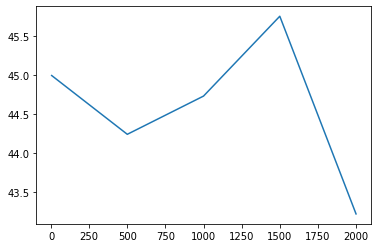

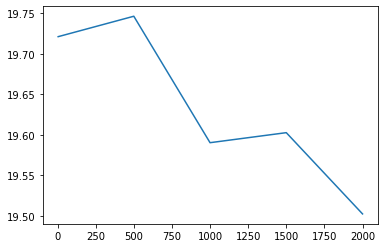

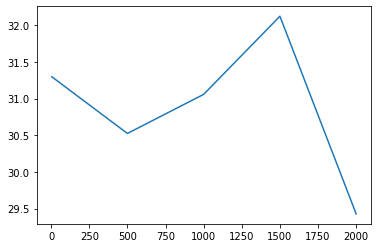

In [13]:
#analysis
accuracymean = np.mean(accuracy, 0)
baccuracymean = np.mean(baccuracy, 0)
fscoremean = np.mean(fscore, 0)
print(accuracymean, baccuracymean, fscoremean)
print(accuracy, baccuracy, fscore)
plt.plot(n_mix, accuracymean)
plt.show()
plt.plot(n_mix, baccuracymean)
plt.show()
plt.plot(n_mix, fscoremean)
plt.show()

In [ ]:
for i in :
    print("Test data: Accuracy:", np.mean(ypred == yval) * 100)
    print("Test data: Balanced accuracy:", balanced_accuracy_score(ypred, yval) * 100)
    #print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
    print("Test: Weighted F1-Score:", round(f1_score(ypred, yval, average='weighted') * 100, 3), '%')
    print()

In [ ]:
if verbose:
    label_dict = {'chew': 0, 'elpp': 1, 'eyem': 2, 'musc': 3, 'shiv': 4, 'null': 5}
    print()
    print(classification_report(np.tile(y, n_repeats), y_pred_classes.flatten(), target_names=list(label_dict.keys())))
    for key in best_hyperparametes[0].keys():
        print("{} : ".format(key), end="")
        if not isinstance(best_hyperparametes[0][key], float):
            print([best[key] for best in best_hyperparametes])
        else:
            print([round(best[key], 3) for best in best_hyperparametes])

    print(["{:.3f}".format(np.mean(ypred.flatten()[np.tile(y, n_repeats) == i] == i)) for i in range(6)])